In [1]:
#pip install ee

In [2]:
#pip install geemap

In [3]:
import ee
import geemap
import pandas as pd
import numpy as np 
from matplotlib import pyplot
from io import StringIO


#ee.Authenticate()  # Only needed for the first time
ee.Initialize()
Map= geemap.Map()

In [4]:
lake = ee.FeatureCollection('projects/ee-touheda-khanom/assets/samplinglakes') \
    .filter(ee.Filter.eq('GNIS_Name', 'Big Moose Lake'))

station = ee.Geometry.Point(-74.85423940003443,43.81880036802749)
Map.addLayer(station)
Map.centerObject(station, 16)

Map.addLayer(lake)
Map.centerObject(lake, 16)
Map

Map(center=[43.83093869244275, -74.84826397158908], controls=(WidgetControl(options=['position', 'transparent_…

In [5]:
sentinel2_bands =['B1','B2','B3','B4','B5','B6','B8','B8A','B11']
STD_NAMES = ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1','RedEdge2','RedEdge4','NIR','SWIR1']

In [6]:
def cdom(img):
    cdo = img.expression("(20.3 - 10. * (b2 / b3) - 2.4 * (b3 / b4))", {
        'b1': img.select('Aerosols'),
        'b2': img.select('Blue'),
        'b3': img.select('Green'),
        'b4': img.select('Red')
    }).rename("CO")
    
    bad2 = cdo.where(cdo.gte(0), 1).rename("bad2")
    co = cdo.multiply(bad2).rename("CO")
    mask = co.neq(0)

    return img.addBands(co).clip(lake).updateMask(mask)


In [7]:
def maskS2clouds(image):
    qa = image.select('QA60')
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Create the cloud mask
    cloudMask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    # Apply the cloud mask to the image
    maskedImage = image.updateMask(cloudMask)

    return maskedImage

s2 = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filter(ee.Filter.calendarRange(1,12, 'month')) \
    .filterBounds(station) \
    .map(maskS2clouds) \
    .select(sentinel2_bands, STD_NAMES) \
    .map(cdom)\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 25)) 
    
    
#     .filter(ee.Filter.date('2019-09-17', '2019-09-19'))\
#     .filter(ee.Filter.calendarRange(15,20, 'day')) \


In [8]:
Map.addLayer(s2.first())
Map

Map(center=[43.83093869244275, -74.84826397158908], controls=(WidgetControl(options=['position', 'transparent_…

In [9]:
image = s2.toList(s2.size())
last_image = ee.Image(image.get(-1))
geemap.image_props(last_image).getInfo()

{'AOT_RETRIEVAL_ACCURACY': 0,
 'AOT_RETRIEVAL_METHOD': 'SEN2COR_DDV',
 'BOA_ADD_OFFSET_B1': -1000,
 'BOA_ADD_OFFSET_B10': -1000,
 'BOA_ADD_OFFSET_B11': -1000,
 'BOA_ADD_OFFSET_B12': -1000,
 'BOA_ADD_OFFSET_B2': -1000,
 'BOA_ADD_OFFSET_B3': -1000,
 'BOA_ADD_OFFSET_B4': -1000,
 'BOA_ADD_OFFSET_B5': -1000,
 'BOA_ADD_OFFSET_B6': -1000,
 'BOA_ADD_OFFSET_B7': -1000,
 'BOA_ADD_OFFSET_B8': -1000,
 'BOA_ADD_OFFSET_B8A': -1000,
 'BOA_ADD_OFFSET_B9': -1000,
 'CLOUDY_PIXEL_OVER_LAND_PERCENTAGE': 1.604859,
 'CLOUDY_PIXEL_PERCENTAGE': 1.841278,
 'CLOUD_COVERAGE_ASSESSMENT': 1.841278,
 'CLOUD_SHADOW_PERCENTAGE': 0.040046,
 'DARK_FEATURES_PERCENTAGE': 0.204661,
 'DATASTRIP_ID': 'S2B_OPER_MSI_L2A_DS_2BPS_20230530T200423_S20230530T155930_N05.09',
 'DATATAKE_IDENTIFIER': 'GS2B_20230530T154819_032541_N05.09',
 'DATATAKE_TYPE': 'INS-NOBS',
 'DEGRADED_MSI_DATA_PERCENTAGE': 0.0005,
 'FORMAT_CORRECTNESS': 'PASSED',
 'GENERAL_QUALITY': 'PASSED',
 'GENERATION_TIME': 1685477063000,
 'GEOMETRIC_QUALITY': 'PASSED'

In [10]:
#image = se.first()

In [11]:
imageFirst = s2.first()
geemap.image_props(imageFirst).getInfo()

{'AOT_RETRIEVAL_ACCURACY': 0,
 'CLOUDY_PIXEL_PERCENTAGE': 17.490407,
 'CLOUD_COVERAGE_ASSESSMENT': 17.490407,
 'CLOUD_SHADOW_PERCENTAGE': 1.797247,
 'DARK_FEATURES_PERCENTAGE': 0.573402,
 'DATASTRIP_ID': 'S2A_OPER_MSI_L2A_DS_SGS__20190615T195536_S20190615T155624_N02.12',
 'DATATAKE_IDENTIFIER': 'GS2A_20190615T154911_020786_N02.12',
 'DATATAKE_TYPE': 'INS-NOBS',
 'DEGRADED_MSI_DATA_PERCENTAGE': 0,
 'FORMAT_CORRECTNESS': 'PASSED',
 'GENERAL_QUALITY': 'PASSED',
 'GENERATION_TIME': 1560628536000,
 'GEOMETRIC_QUALITY': 'PASSED',
 'GRANULE_ID': 'L2A_T18TWP_A020786_20190615T155624',
 'HIGH_PROBA_CLOUDS_PERCENTAGE': 11.655708,
 'IMAGE_DATE': '2019-06-15',
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B1': 199.285898917,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B10': 200.999225339,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B11': 199.32133475,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B12': 198.435250802,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B2': 205.289363778,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B3': 202.860968058,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B4': 

In [12]:
print(s2.getInfo())

{'type': 'ImageCollection', 'bands': [], 'id': 'COPERNICUS/S2_SR', 'version': 1689626818383502, 'properties': {'date_range': [1490659200000, 1647907200000], 'period': 0, 'system:visualization_0_min': '0.0', 'type_name': 'ImageCollection', 'keywords': ['copernicus', 'esa', 'eu', 'msi', 'reflectance', 'sentinel', 'sr'], 'system:visualization_0_bands': 'B4,B3,B2', 'thumb': 'https://mw1.google.com/ges/dd/images/COPERNICUS_S2_SR_thumb.png', 'description': '<p>Sentinel-2 is a wide-swath, high-resolution, multi-spectral\nimaging mission supporting Copernicus Land Monitoring studies,\nincluding the monitoring of vegetation, soil and water cover,\nas well as observation of inland waterways and coastal areas.</p><p>The Sentinel-2 L2 data are downloaded from scihub. They were\ncomputed by running sen2cor. WARNING: ESA did not produce L2 data\nfor all L1 assets, and earlier L2 coverage is not global.</p><p>The assets contain\n12 UINT16 spectral bands representing SR scaled by 10000 (unlike in L1 d

In [13]:
vis_params = {'bands': ['Red', 'Green', 'Blue'], 'min': 0.0, 'max': 100.0, 'opacity': 1.0, 'gamma': 1.0}

In [14]:
vis_params = {'bands': ['Red', 'Green', 'Blue'], 'min': 0.0, 'max': 100.0, 'opacity': 1.0, 'gamma': 1.0}

In [15]:
 first_image = s2.first()  # Get the first image from the collection
band_names = first_image.bandNames().getInfo()
print("Band Names:", band_names)

Band Names: ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge4', 'NIR', 'SWIR1', 'CO']


In [16]:
#How many images?
print(s2.size().getInfo())


55


In [17]:
def station_mean(img): # station_mean function with a single parameter img
    #mean of a specific band (CO) within a region 
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=lake, scale=30).get('CO')
    return img.set('date', img.date().format()).set('CDOM',mean)

station_reduced_imgs = s2.map(station_mean)
nested_list = station_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','CDOM']).values().get(0)
df = pd.DataFrame(nested_list.getInfo(), columns=['date','CDOM'])

df = pd.DataFrame(nested_list.getInfo(), columns=['date','CDOM'])
pd.set_option('display.max_rows', None)

df

,date,CDOM
0,2019-06-15T16:01:07,7.140011
1,2019-07-10T16:01:15,6.881957
2,2019-08-14T16:01:07,7.358481
3,2019-09-13T16:01:02,8.061198
4,2019-09-18T16:01:03,4.300284
5,2019-10-08T16:01:05,12.680653
6,2019-10-13T16:01:07,16.020416
7,2019-11-17T16:01:02,10811.068138
8,2020-03-01T16:00:59,7.756619
9,2020-03-16T16:01:02,7.752863


In [18]:
df['date'] = pd.to_datetime(df['date'])

# Format 'date' column to exclude the time
df['date'] = df['date'].dt.date
df

,date,CDOM
0,2019-06-15,7.140011
1,2019-07-10,6.881957
2,2019-08-14,7.358481
3,2019-09-13,8.061198
4,2019-09-18,4.300284
5,2019-10-08,12.680653
6,2019-10-13,16.020416
7,2019-11-17,10811.068138
8,2020-03-01,7.756619
9,2020-03-16,7.752863


In [19]:
# import pandas as pd

# # Filter out CDOM values greater than 20
# df = df[df['CDOM'] <= 20]


# df

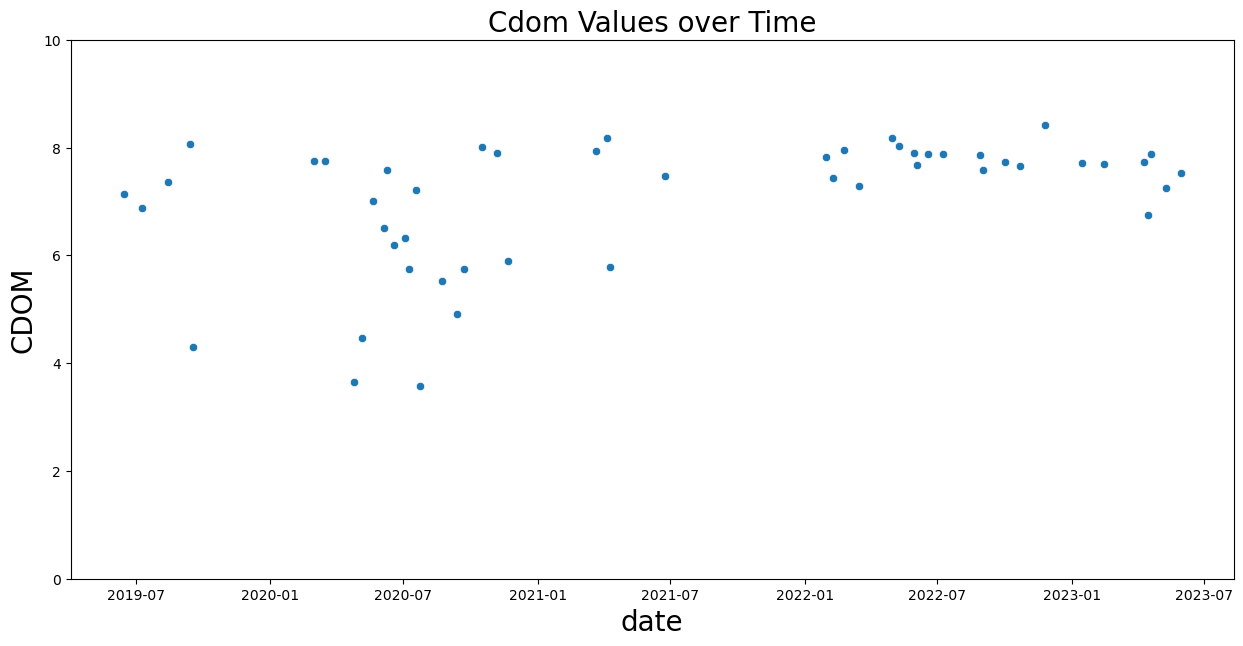

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
# Create a figure with subplots and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15, 7))

# Create the plot by setting our dataframe to the data argument
sns.scatterplot(data=df, x='date', y='CDOM', ax=ax)

# Set the labels and title
ax.set_ylabel('CDOM', fontsize=20)
ax.set_xlabel('date', fontsize=20)
ax.set_title('Cdom Values over Time', fontsize=20)
ax.set_ylim(0,10)

# Format the x-axis tick labels to display only the year
# ax.xaxis.set_major_formatter(plt.FixedFormatter(df['date'].dt.year.unique()))

# Display the plot
plt.show()


In [21]:
def reflectance(img): 
    #img is used to calculate the mean of specific bands indicated by STD_NAMES
    reflectance_values = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=station, scale=30).select(STD_NAMES)
    return ee.Feature(None, {'date': img.date().format(), 'reflectance': reflectance_values})

s2_reflectance = s2.map(reflectance)
s2_list = s2_reflectance.reduceColumns(ee.Reducer.toList(2), ['date', 'reflectance']).values().get(0)
df_s2_reflectance = pd.DataFrame(s2_list.getInfo(), columns=['date', 'reflectance'])

# Convert date column to datetime and extract date only
df_s2_reflectance['date'] = pd.to_datetime(df_s2_reflectance['date']).dt.date

# Set the reflectance column values to a dictionary
df_s2_reflectance['reflectance'] = df_s2_reflectance['reflectance'].apply(lambda x: {k: v for k, v in x.items() if v is not None})
df_s2_reflectance

,date,reflectance
0,2019-06-15,"{'Aerosols': 353, 'Blue': 233, 'Green': 213, '..."
1,2019-07-10,"{'Aerosols': 654, 'Blue': 719, 'Green': 505, '..."
2,2019-08-14,"{'Aerosols': 499, 'Blue': 316, 'Green': 475, '..."
3,2019-09-13,"{'Aerosols': 184, 'Blue': 128, 'Green': 139, '..."
4,2019-09-18,"{'Aerosols': 77, 'Blue': 76, 'Green': 64, 'NIR..."
5,2019-10-08,"{'Aerosols': 18, 'Blue': 55, 'Green': 20, 'NIR..."
6,2019-10-13,"{'Aerosols': 17, 'Blue': 5, 'Green': 13, 'NIR'..."
7,2019-11-17,"{'Aerosols': 111, 'Blue': 46, 'Green': 2, 'NIR..."
8,2020-03-01,"{'Aerosols': 8631, 'Blue': 10079, 'Green': 981..."
9,2020-03-16,"{'Aerosols': 3062, 'Blue': 5307, 'Green': 5258..."


In [22]:
# Create empty lists to store the data
data = []

# Extract the bands, reflectance values, and dates where available
for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    if reflectance:
        for band in STD_NAMES:
            value = reflectance.get(band)
            data.append({'Band': band, 'Reflectance': value, 'Date': date})

# Create a dataframe from the data
df_data = pd.DataFrame(data)

# Display the dataframe
print(df_data)

         Band  Reflectance        Date
0    Aerosols        353.0  2019-06-15
1        Blue        233.0  2019-06-15
2       Green        213.0  2019-06-15
3         Red        176.0  2019-06-15
4    RedEdge1        186.0  2019-06-15
5    RedEdge2        169.0  2019-06-15
6    RedEdge4        179.0  2019-06-15
7         NIR        200.0  2019-06-15
8       SWIR1        178.0  2019-06-15
9    Aerosols        654.0  2019-07-10
10       Blue        719.0  2019-07-10
11      Green        505.0  2019-07-10
12        Red        500.0  2019-07-10
13   RedEdge1        693.0  2019-07-10
14   RedEdge2       1263.0  2019-07-10
15   RedEdge4       1390.0  2019-07-10
16        NIR       1275.0  2019-07-10
17      SWIR1        841.0  2019-07-10
18   Aerosols        499.0  2019-08-14
19       Blue        316.0  2019-08-14
20      Green        475.0  2019-08-14
21        Red        535.0  2019-08-14
22   RedEdge1        592.0  2019-08-14
23   RedEdge2        722.0  2019-08-14
24   RedEdge4        716.

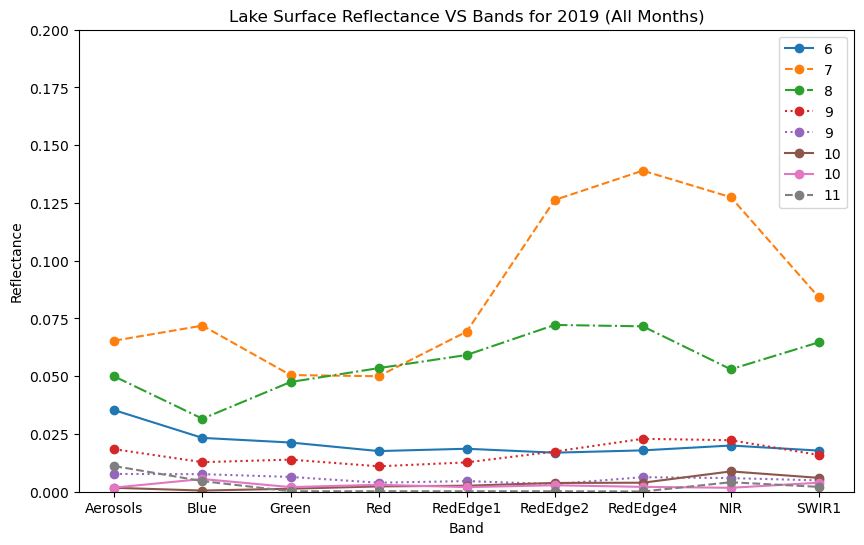

In [23]:
data_by_month = {}

for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    year = date.year
    
    if year == 2019:
        month = date.month
        
        if month not in data_by_month:
            data_by_month[month] = {'band': [], 'dates': [], 'reflectance': []}
        
        if reflectance:
            for band in STD_NAMES:
                value = reflectance.get(band)
                if value is not None:
                    value /= 10000  # Divide by 10000 to convert from DN to reflectance
                    data_by_month[month]['band'].append(band)
                    data_by_month[month]['dates'].append(date)
                    data_by_month[month]['reflectance'].append(value)

plt.figure(figsize=(10, 6))

line_styles = ['-', '--', '-.', ':']  # List of line styles
num_styles = len(line_styles)
style_index = 0

for month, data in data_by_month.items():
    unique_dates = list(set(data['dates']))  # Get unique dates for the month
    line_style = line_styles[style_index % num_styles]  # Cycle through line styles
    
    for date in unique_dates:
        indices = [i for i, d in enumerate(data['dates']) if d == date]  # Get indices for the specific date
        reflectance_values = [data['reflectance'][i] for i in indices]
        bands = [data['band'][i] for i in indices]
        plt.plot(bands, reflectance_values, linestyle=line_style, marker='o', label=month)
    
    style_index += 1

plt.xlabel('Band')
plt.ylabel('Reflectance')
plt.ylim(0, 0.2)  # Adjust the y-axis limit based on the reflectance range
plt.title('Lake Surface Reflectance VS Bands for 2019 (All Months)')
plt.legend()
plt.show()


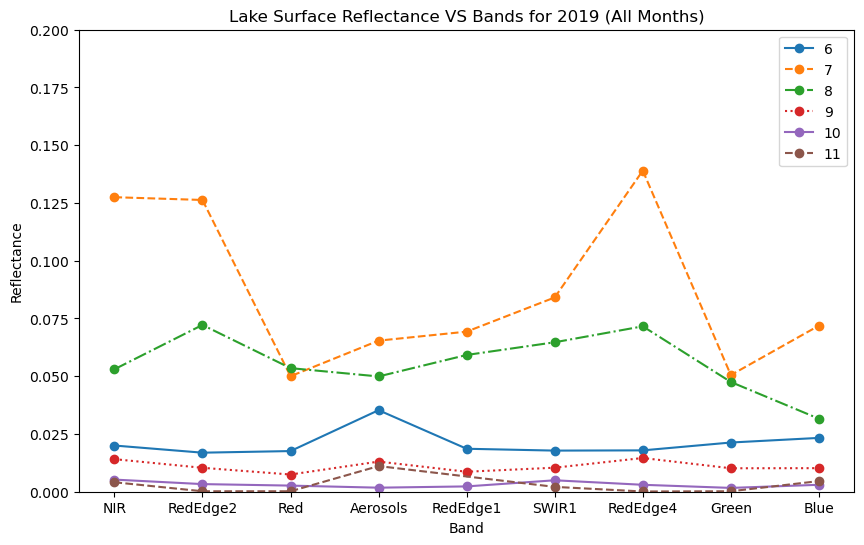

In [28]:
data_by_month = {}
monthly_average_reflectance = {}  # New dictionary to store average reflectance values

for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    year = date.year
    
    if year == 2019:
        month = date.month
        
        if month not in data_by_month:
            data_by_month[month] = {'band': [], 'dates': [], 'reflectance': []}
        
        if reflectance:
            for band in STD_NAMES:
                value = reflectance.get(band)
                if value is not None:
                    value /= 10000  # Divide by 10000 to convert from DN to reflectance
                    data_by_month[month]['band'].append(band)
                    data_by_month[month]['dates'].append(date)
                    data_by_month[month]['reflectance'].append(value)

# Calculate the average reflectance for each band for each month
for month, data in data_by_month.items():
    unique_bands = list(set(data['band']))
    average_reflectance = []
    for band in unique_bands:
        indices = [i for i, b in enumerate(data['band']) if b == band]
        reflectance_values = [data['reflectance'][i] for i in indices]
        avg_reflectance = sum(reflectance_values) / len(reflectance_values)
        average_reflectance.append(avg_reflectance)
    monthly_average_reflectance[month] = {'band': unique_bands, 'reflectance': average_reflectance}

plt.figure(figsize=(10, 6))

line_styles = ['-', '--', '-.', ':']  # List of line styles
num_styles = len(line_styles)
style_index = 0

for month, data in monthly_average_reflectance.items():
    line_style = line_styles[style_index % num_styles]  # Cycle through line styles
    plt.plot(data['band'], data['reflectance'], linestyle=line_style, marker='o', label=month)
    
    style_index += 1

plt.xlabel('Band')
plt.ylabel('Reflectance')
plt.ylim(0, 0.2)  # Adjust the y-axis limit based on the reflectance range
plt.title('Lake Surface Reflectance VS Bands for 2019 (All Months)')
plt.legend()
plt.show()


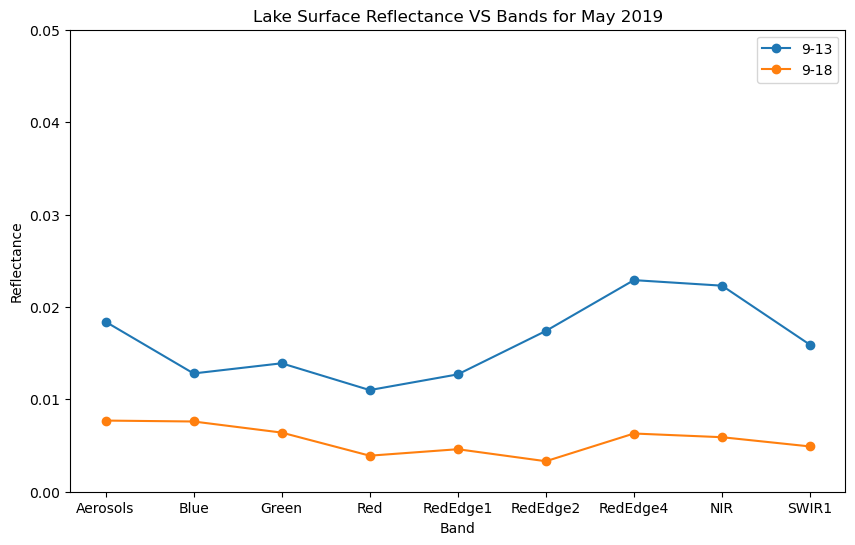

In [26]:
data_by_month = {}

for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    year = date.year
    
    if year == 2019 and date.month == 9:
        month = date.month
        
        if month not in data_by_month:
            data_by_month[month] = {'band': [], 'dates': [], 'reflectance': []}
        
        if reflectance:
            for band in STD_NAMES:
                value = reflectance.get(band)
                if value is not None:
                    value /= 10000  # Divide by 10000 to convert from DN to reflectance
                    data_by_month[month]['band'].append(band)
                    data_by_month[month]['dates'].append(date)
                    data_by_month[month]['reflectance'].append(value)

plt.figure(figsize=(10, 6))

line_styles = ['-', '--', '-.', ':']  # List of line styles
num_styles = len(line_styles)
style_index = 0

for month, data in data_by_month.items():
    unique_dates = list(set(data['dates']))  # Get unique dates for the month
    line_style = line_styles[style_index % num_styles]  # Cycle through line styles
    
    for date in unique_dates:
        indices = [i for i, d in enumerate(data['dates']) if d == date]  # Get indices for the specific date
        reflectance_values = [data['reflectance'][i] for i in indices]
        bands = [data['band'][i] for i in indices]
        plt.plot(bands, reflectance_values, linestyle=line_style, marker='o', label=f'{month}-{date.day}')
    
    style_index += 1

plt.xlabel('Band')
plt.ylabel('Reflectance')
plt.ylim(0, 0.05)  # Adjust the y-axis limit based on the reflectance range
plt.title('Lake Surface Reflectance VS Bands for May 2019')
plt.legend()
plt.show()


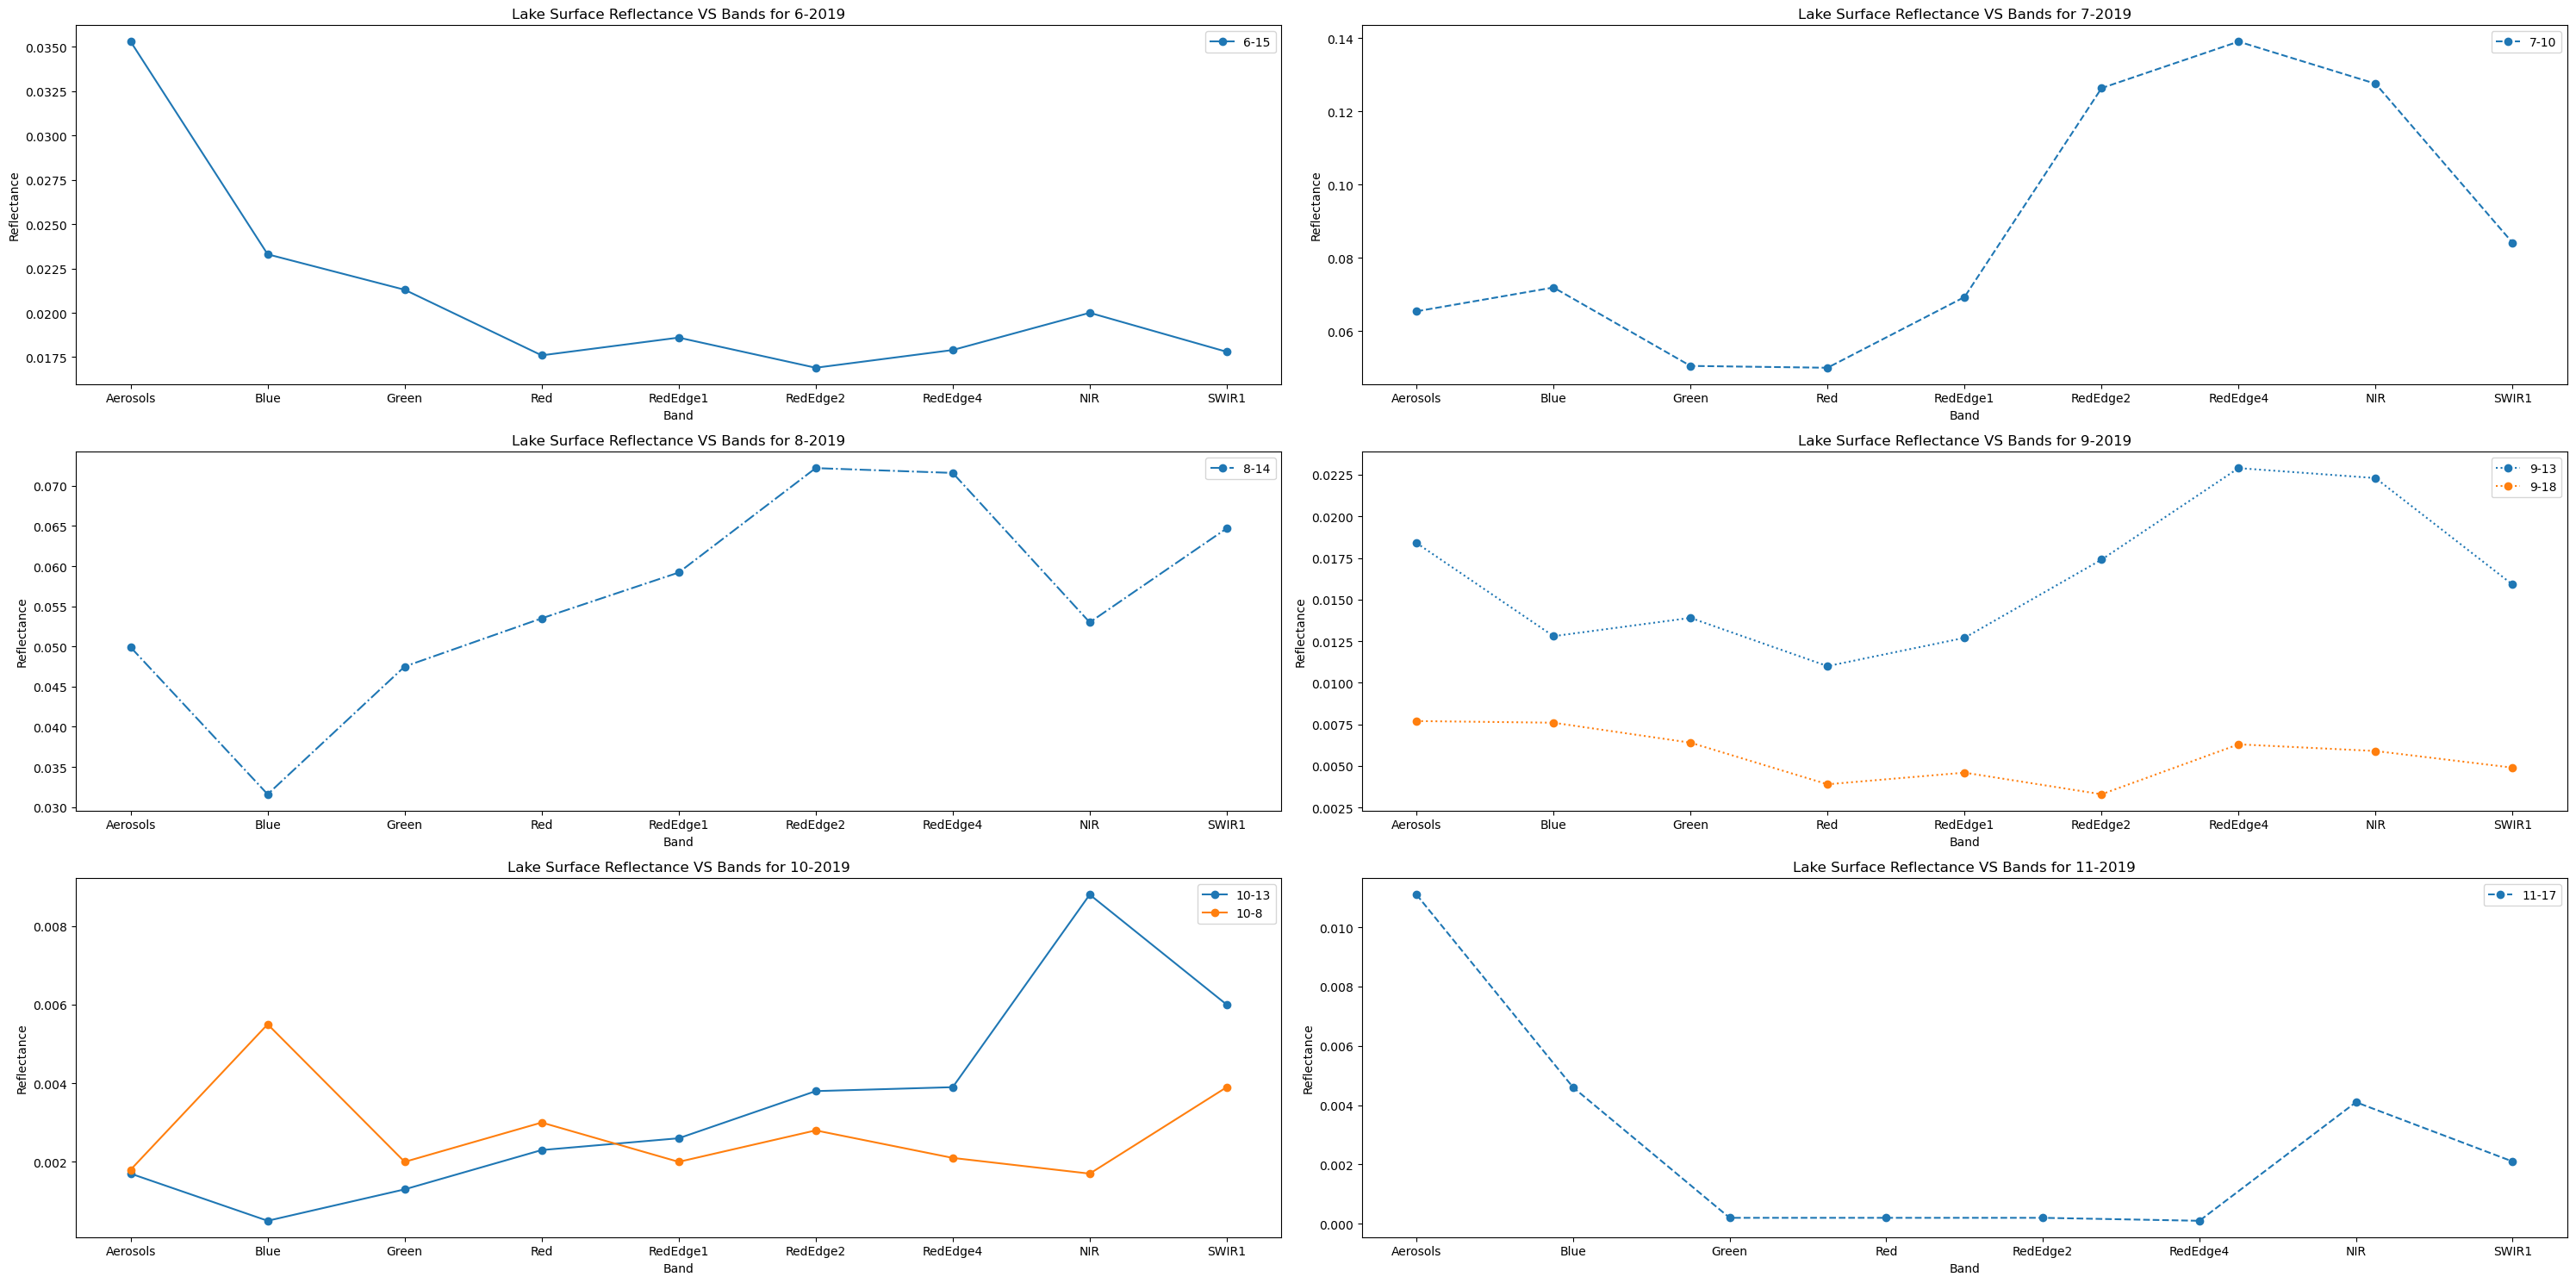

In [27]:
data_by_month = {}

# Iterate over the dataframe rows
for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    year = date.year
    
    # Filter data for specific months
    if year == 2019 and date.month in [3,4,5,6,7,8,9,10,11,12]:
        month = date.month
        
        if month not in data_by_month:
            data_by_month[month] = {'band': [], 'dates': [], 'reflectance': []}
        
        if reflectance:
            for band in STD_NAMES:
                value = reflectance.get(band)
                if value is not None:
                    value /= 10000  # Divide by 10000 to convert from DN to reflectance
                    data_by_month[month]['band'].append(band)
                    data_by_month[month]['dates'].append(date)
                    data_by_month[month]['reflectance'].append(value)

# Define plot parameters
line_styles = ['-', '--', '-.', ':']  # List of line styles
num_styles = len(line_styles)

# Calculate the number of rows and columns for the subplots
num_months = len(data_by_month)
num_cols = 2  # Number of subplots per row
num_rows = (num_months + num_cols - 1) // num_cols

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(30, 5 * num_rows))

# Flatten the axs array to iterate over subplots
axs = axs.flatten()

# Iterate over the data for each month
for i, (month, data) in enumerate(data_by_month.items()):
    unique_dates = list(set(data['dates']))  # Get unique dates for the month
    line_style = line_styles[i % num_styles]  # Cycle through line styles
    
    axs[i].set_xlabel('Band')
    axs[i].set_ylabel('Reflectance')
#     axs[i].set_ylim(0, 0.05)  # Adjust the y-axis limit based on the reflectance range
    axs[i].set_title(f'Lake Surface Reflectance VS Bands for {month}-2019')
    
    # Plot data for each unique date
    for date in unique_dates:
        indices = [j for j, d in enumerate(data['dates']) if d == date]  # Get indices for the specific date
        reflectance_values = [data['reflectance'][j] for j in indices]
        bands = [data['band'][j] for j in indices]
        axs[i].plot(bands, reflectance_values, linestyle=line_style, marker='o', label=f'{month}-{date.day}')
    
    axs[i].legend()

# Hide any unused subplots
for j in range(num_months, num_rows * num_cols):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


In [31]:
# FInd DOC 
import pandas as pd

# Read the data from the Excel file
data_doc = pd.read_excel('LTM_Data_2023_3_9.xlsx', index_col=0, parse_dates=True)

data_doc = data_doc[data_doc['DOC_MG_L'].notnull()]

# Sort the DataFrame by 'DATE_SMP' column in ascending order
data_doc = data_doc.sort_values(by='DATE_SMP')

# Select the 'DATE_SMP' and 'DOC_MG_L' columns
data = data_doc[['DATE_SMP', 'DOC_MG_L']].rename(columns={'DATE_SMP': 'Date', 'DOC_MG_L': 'DOC'})


# Set the display options to expand all rows
# Use the pd.options.display context manager to show all rows
with pd.option_context('display.max_rows', None):
    print(data)



                          Date         DOC
SITE_ID                                   
1A1-110    1982-06-30 00:00:00    3.300000
1A2-077    1982-06-30 00:00:00    5.200000
1A1-103    1982-06-30 00:00:00    4.000000
1A1-107    1982-06-30 00:00:00   14.000000
1A1-102    1982-06-30 00:00:00    4.000000
1A1-106    1982-06-30 00:00:00    2.900000
1A1-109    1982-06-30 00:00:00    3.800000
1A1-109    1982-07-29 00:00:00    5.200000
1A1-102    1982-07-29 00:00:00    3.900000
1A2-077    1982-07-29 00:00:00    4.300000
1A1-107    1982-07-29 00:00:00   13.400000
1A1-106    1982-07-29 00:00:00    3.900000
1A1-103    1982-07-29 00:00:00    5.200000
1A1-110    1982-07-29 00:00:00    3.200000
1A1-102    1982-08-31 00:00:00    3.800000
1A1-109    1982-08-31 00:00:00    3.300000
1A1-103    1982-08-31 00:00:00    2.900000
1A1-106    1982-08-31 00:00:00    2.600000
1A2-077    1982-08-31 00:00:00    3.800000
1A1-110    1982-08-31 00:00:00    3.200000
1A1-107    1982-08-31 00:00:00   11.400000
1A1-103    

In [ ]:
# CDOM vs DOC Scatterplot 

In [ ]:
# Lakes Median 